In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Brewer's Friend Beer Recipes

# Indice

1. Introducción
2. Carga y Análisis Dataset
3. Preprocessing
4. Modelos y Entrenamiento
5. Validación y Estudio
6. Conclusión

# Introducción

https://www.kaggle.com/jtrofe/beer-recipes

El dataset que estudiaremos es sobre cervezas caseras de una web llamada Brewer's Friend: https://www.brewersfriend.com/

Como objetivo principal queremos poder clasificar entre los 175 estilos de cerveza en la que cada cerveza casera está dividida

# Carga y Análisis Dataset

Primero de todo cargamos el dataset y observamos lo que contiene

In [2]:
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

recipe_dataset = load_dataset('recipeData.csv')
style_dataset = load_dataset('styleData.csv')

print(recipe_dataset.head())
print(style_dataset.head())

   BeerID                             Name  \
0       1                Vanilla Cream Ale   
1       2      Southern Tier Pumking clone   
2       3      Zombie Dust Clone - EXTRACT   
3       4    Zombie Dust Clone - ALL GRAIN   
4       5  Bakke Brygg Belgisk Blonde 50 l   

                                                 URL  \
0       /homebrew/recipe/view/1633/vanilla-cream-ale   
1  /homebrew/recipe/view/16367/southern-tier-pumk...   
2  /homebrew/recipe/view/5920/zombie-dust-clone-e...   
3  /homebrew/recipe/view/5916/zombie-dust-clone-a...   
4  /homebrew/recipe/view/89534/bakke-brygg-belgis...   

                                Style  StyleID  Size(L)     OG     FG   ABV  \
0                           Cream Ale       45    21.77  1.055  1.013  5.48   
1  Holiday/Winter Special Spiced Beer       85    20.82  1.083  1.021  8.16   
2                        American IPA        7    18.93  1.063  1.018  5.91   
3                        American IPA        7    22.71  1.061  1.017 

Los atributos de nuestro primer csv recipe_dataset son:
  * BeerID: ID de cada cerveza  
  * Name: Nombre de la cerveza casera  
  * URL: Ubicación donde se encuentra cada cerveza casera dentro de la web de donde se ha extraído el dataset
  * Style: Tipo de cerveza
  * StyleID: ID numérico del tipo de cerveza
  * Size(L): Cantidad elaborada para la receta indicada en litros
  * OG: Gravedad específica del mosto antes de la fermentación
  * FG: Gravedad específica del mosto después de la fermentación
  * ABV: Alcohol por volumen
  * IBU: Unidades internacionales de amargor
  * Color: Método de referencia estándar de claro a oscuro
  * BoilSize: Líquido al comiendo de la ebullición
  * BoilTime: Tiempo de ebullición
  * BoilGravity: Gravedad específica del mosto antes de la ebullición
  * Efficiency: Eficiencia de extracción del puré de la cerveza (extracción de azúcares del grano durante el puré)
  * MashThickness: Cantidad de agura por libra de grano
  * SugarScale: Escala para determinar la concentración de sólidos disueltos en el mosto
  * BrewMethod: Técnica empleada en la elaboración de la cerveza
  * PitchRate: Levadura añadida al fermentador por unidad de gravedad
  * PrimaryTemp: Temperatura en la etapa de fermentación
  * PrimingMethod: Método de imprimación utilizada
  * PrimingAmount: Cantidad de azúcar de imprimación utilizada
  * UserId: ID de cada usuario

En el otro cvs style_dataset solo tenemos dos atributos los cuales son:
  * Style: Tipos de cerveza
  * StyleID: ID numérico del tipo de cerveza

Podemos observar que las columnas del primer dataset llamadas Style y StyleID coinciden con las de nuestro segundo dataset. Es por ello que este segundo dataset practicamente no lo utilizaremos.  
Esto podemos comprovarlo ya que se cumple el siguiente código:

In [3]:
print(len(style_dataset) == len(recipe_dataset['Style'].unique()))

True


---

Nos toca comprovar que cantidad de nulls obtenemos de todos los atributos:

PrimingAmount    69087
PrimingMethod    67095
UserId           50490
PitchRate        39252
MashThickness    29864
PrimaryTemp      22662
BoilGravity       2990
Style              596
Name                 1
BrewMethod           0
SugarScale           0
Efficiency           0
BeerID               0
BoilTime             0
Color                0
IBU                  0
ABV                  0
FG                   0
OG                   0
Size(L)              0
StyleID              0
URL                  0
BoilSize             0
dtype: int64


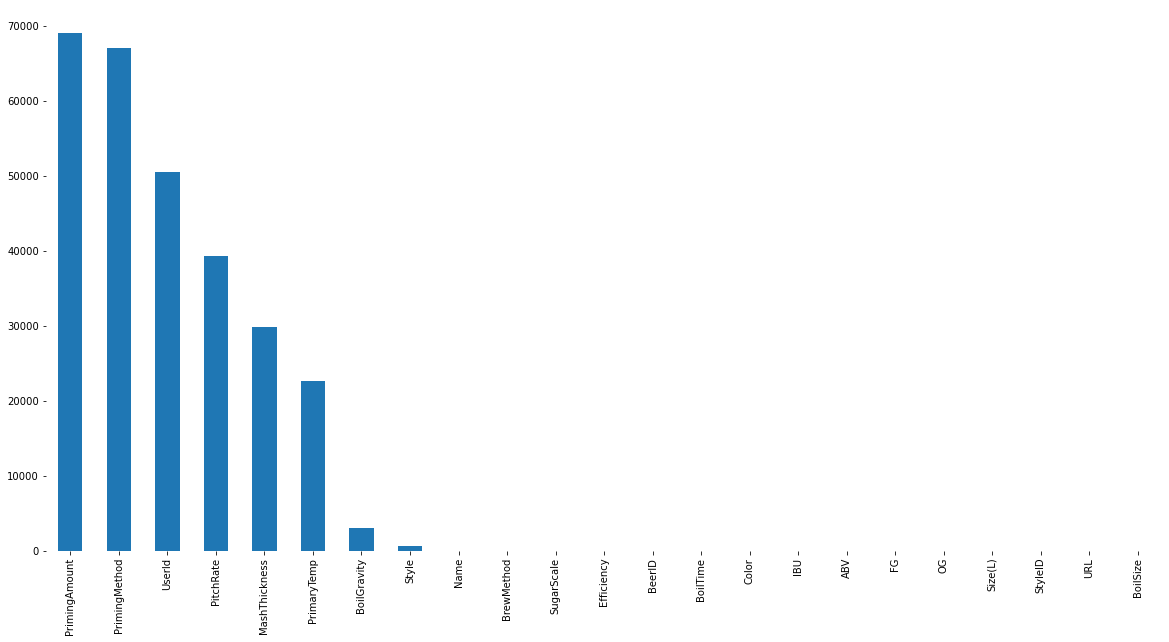

In [4]:
nulls = recipe_dataset.isnull().sum()
nulls.sort_values(inplace=True, ascending=False)
nulls.plot(kind='bar',stacked=True,figsize=(20,10))
sns.despine(left=True, bottom=True)
print(nulls)
plt.show()

<AxesSubplot:>

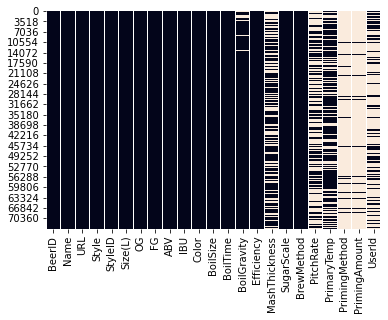

In [5]:
sns.heatmap(recipe_dataset.isnull(), cbar=False)

Viendo los resultados que obtenemos de los null he considerado directamente no utilizar esas variables que tienen una gran cantidad de falta de información, ja que tratarlos con la media, la moda u otros metodos solo generarían muchos datos no reales, que no es lo que estamos buscando a la hora de querer clasificar las diferentes cervezas.

Las únicas que vale la pena tratar son las de BoilGravity, Name, ya que tienen una cantidad reducida de nulls y nos podrían servir más adelante. Las trataremos con la media, la moda respectivamente.

Para el caso de Style, aun teniendo StyleID que nos facilita mucho a la hora de trabajar como si fuese el tarjet, creamos un nuevo estilo llamado 'Unknown' para evitar estos nulls en esta clase de tipo string por si quisieramos utilizarla más adelante.

In [6]:
recipe_dataset["BoilGravity"].fillna(recipe_dataset["BoilGravity"].median(), inplace=True)
recipe_dataset["Name"].fillna(recipe_dataset['Name'].mode()[0], inplace=True)

recipe_dataset['Style'].fillna('Unknown', inplace=True)

In [7]:
recipe_dataset = recipe_dataset.drop(['PrimingAmount', 'PrimingMethod', 'UserId', 'PitchRate', 'MashThickness', 'PrimaryTemp'], axis=1)

BeerID         0
IBU            0
SugarScale     0
Efficiency     0
BoilGravity    0
BoilTime       0
BoilSize       0
Color          0
ABV            0
Name           0
FG             0
OG             0
Size(L)        0
StyleID        0
Style          0
URL            0
BrewMethod     0
dtype: int64


<AxesSubplot:>

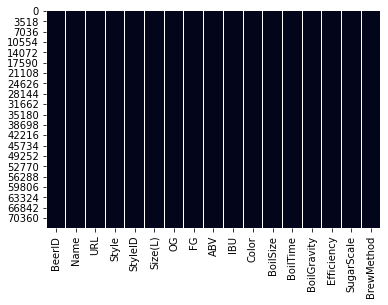

In [8]:
nulls = recipe_dataset.isnull().sum()
nulls.sort_values(inplace=True, ascending=False)
print(nulls)
sns.heatmap(recipe_dataset.isnull(), cbar=False)

---

# Preprocessing

Nos fijaremos ahora en la correlación que tiene todas las variables a estudiar. Recordar que nuestro objetivo es el StyleID para poder clasificar las diferentes bebidas:

<AxesSubplot:>

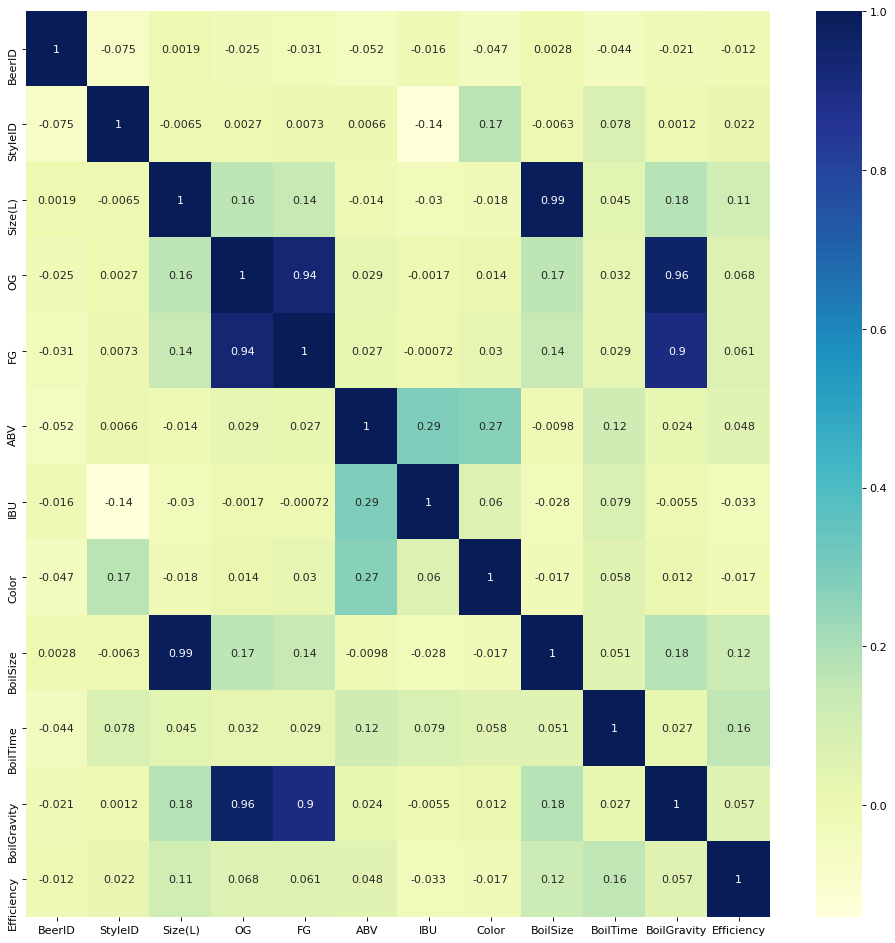

In [9]:
plt.figure(figsize=(15, 15), dpi=80)
sns.heatmap(recipe_dataset.corr(), annot=True, cmap="YlGnBu")

Hay varias variables que no son de tipo float o int que no aparecen, así que vamos a tratarlas para poderlas utilizar y ver su correlación. Estas son; Name, URL, SugarScale y BrewMethod

In [10]:
le = preprocessing.LabelEncoder()
atributes = ['Name', 'URL', 'SugarScale','BrewMethod']
for a in atributes:
    le.fit(recipe_dataset[a])
    recipe_dataset[a] = le.transform(recipe_dataset[a])
print(recipe_dataset.head())

   BeerID   Name    URL                               Style  StyleID  Size(L)  \
0       1  55828   2447                           Cream Ale       45    21.77   
1       2  50102   2468  Holiday/Winter Special Spiced Beer       85    20.82   
2       3  58937  68304                        American IPA        7    18.93   
3       4  58935  68248                        American IPA        7    22.71   
4       5   6957  73415                   Belgian Blond Ale       20    50.00   

      OG     FG   ABV    IBU  Color  BoilSize  BoilTime  BoilGravity  \
0  1.055  1.013  5.48  17.65   4.83     28.39        75        1.038   
1  1.083  1.021  8.16  60.65  15.64     24.61        60        1.070   
2  1.063  1.018  5.91  59.25   8.98     22.71        60        1.047   
3  1.061  1.017  5.80  54.48   8.50     26.50        60        1.047   
4  1.060  1.010  6.48  17.84   4.57     60.00        90        1.050   

   Efficiency  SugarScale  BrewMethod  
0        70.0           1           0  


<AxesSubplot:>

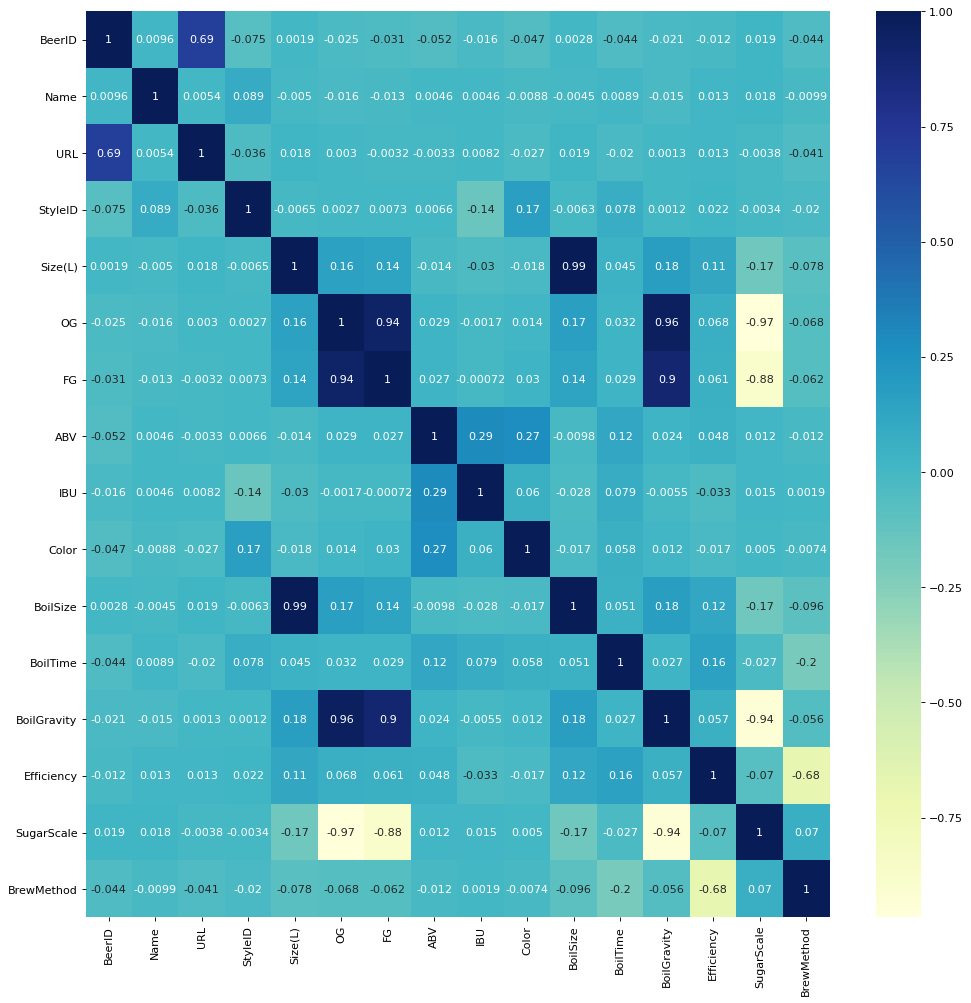

In [11]:
plt.figure(figsize=(15, 15), dpi=80)
sns.heatmap(recipe_dataset.corr(), annot=True, cmap="YlGnBu")

Podemos ver por los colores que en general todas las correlaciones han mejorado considerablemente entre ellas, aunque siguen siendo algo bajas sobretodo para nuestro atributo principal.

Esto me hace pensar que posiblemente el gran problema que tenemos es la cantidad de cervezas que hay. Vamos a verlo.

In [12]:
print("Tipos de cerveza:", len(recipe_dataset['StyleID'].unique()))

Tipos de cerveza: 176


Vamos a ver la cantidad de los 20 tipos de cerveza más repetidos 

7      11940
10      7581
134     2617
9       2277
4       2038
30      1753
86      1478
12      1268
92      1204
6       1152
175     1072
39      1044
169      988
114      961
132      929
170      919
162      919
129      897
94       869
56       864
Name: StyleID, dtype: int64


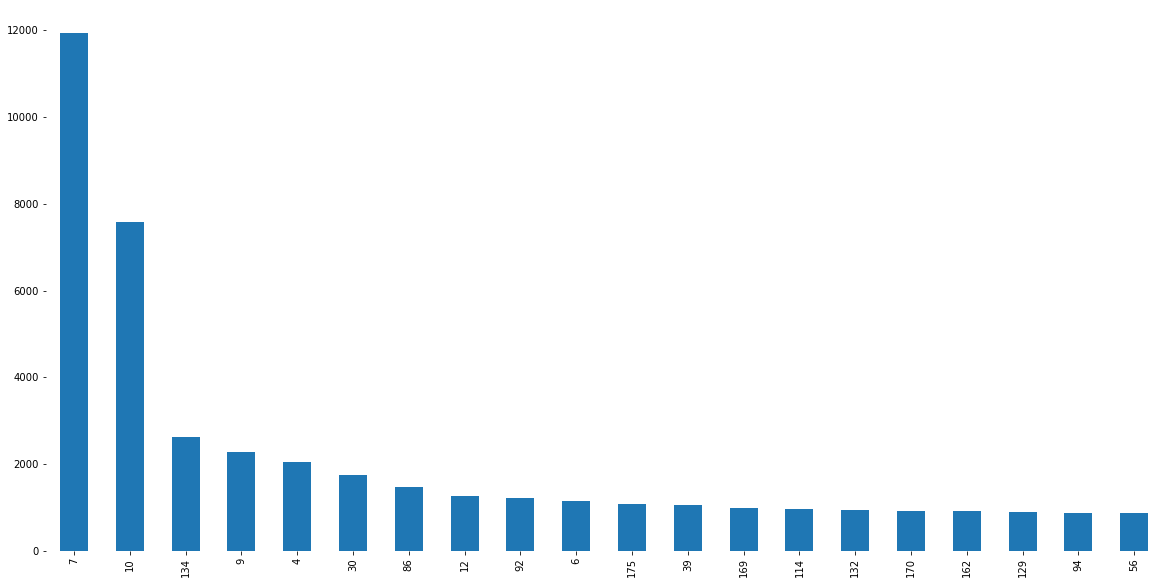

In [13]:
types = 20
popular_recipes = recipe_dataset['StyleID'].value_counts()[:types]
print(popular_recipes)
popular_recipes.plot(kind='bar',stacked=True,figsize=(20,10))
sns.despine(left=True, bottom=True)

Vemos que la cantidad no está muy bien distribuida. Para arreglar esto se me ocurren agrupar las clases en unas que sean más generales y probar ese target a ver su funciona mejor o peor que el que tenemos por defecto cuando estemos trabajando con el modelo.

Estudiando las cervezas vemos que podemos agrupar varios tipos que se repiten bastante, y los demás meterlos todos en 'otros'.

Primero creamos este nuevo atributo con variables de tipo char, i posteriormente las pasamos a int como hemos hecho anteriormente con los atributos que tenían las mismas características y venían por defecto. Necesitaremos recuperar la columna de Style.

In [14]:
generic_styles = ['Ale', 'IPA', 'Pale Ale', 'Lager', 'Stout', 'Bitter', 'Cider', 'Porter']
recipe_dataset['GenericStyle'] = 'Other'
for generic_style in generic_styles:
    recipe_dataset.loc[recipe_dataset['Style'].str.contains(generic_style), 'GenericStyle'] = generic_style

print(recipe_dataset['GenericStyle'])

0          Ale
1        Other
2          IPA
3          IPA
4          Ale
         ...  
73856      Ale
73857      IPA
73858    Other
73859      Ale
73860      IPA
Name: GenericStyle, Length: 73861, dtype: object


In [15]:
le = preprocessing.LabelEncoder()
le.fit(recipe_dataset.GenericStyle)
recipe_dataset['GenericStyleID'] = le.transform(recipe_dataset.GenericStyle)
print(recipe_dataset.head())

   BeerID   Name    URL                               Style  StyleID  Size(L)  \
0       1  55828   2447                           Cream Ale       45    21.77   
1       2  50102   2468  Holiday/Winter Special Spiced Beer       85    20.82   
2       3  58937  68304                        American IPA        7    18.93   
3       4  58935  68248                        American IPA        7    22.71   
4       5   6957  73415                   Belgian Blond Ale       20    50.00   

      OG     FG   ABV    IBU  Color  BoilSize  BoilTime  BoilGravity  \
0  1.055  1.013  5.48  17.65   4.83     28.39        75        1.038   
1  1.083  1.021  8.16  60.65  15.64     24.61        60        1.070   
2  1.063  1.018  5.91  59.25   8.98     22.71        60        1.047   
3  1.061  1.017  5.80  54.48   8.50     26.50        60        1.047   
4  1.060  1.010  6.48  17.84   4.57     60.00        90        1.050   

   Efficiency  SugarScale  BrewMethod GenericStyle  GenericStyleID  
0        70

Other       22502
IPA         17064
Ale         10653
Pale Ale     8206
Stout        5954
Lager        4110
Porter       2700
Bitter       2481
Cider         191
Name: GenericStyle, dtype: int64


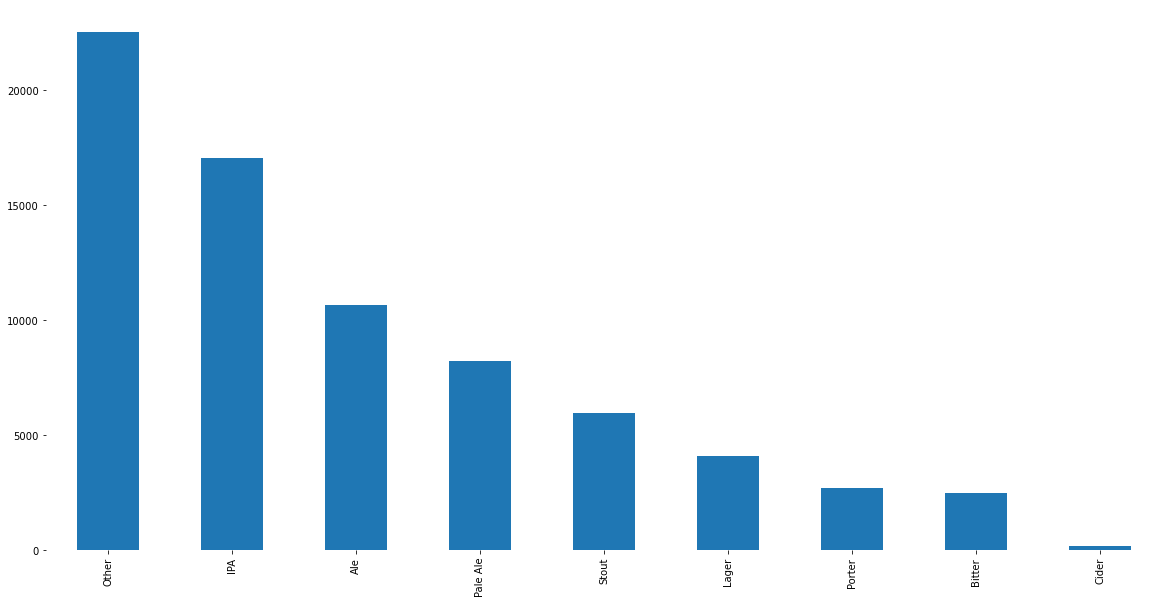

In [16]:
style_popularity_as_perc = recipe_dataset['GenericStyle'].value_counts()
print(style_popularity_as_perc)
style_popularity_as_perc.plot(kind='bar',stacked=True,figsize=(20,10))
sns.despine(left=True, bottom=True)

Hemos reducido considerablemente la cantidad de clases, lo que las proporciones siguen siendo muy diferentes. Posiblemente tengamos que fijarnos en el f1 score, ya que los datos no están bien distribuidos, o utilizar SMOTE para generar más datos de cada tipo de clase hasta llegar al màximo del que tenemos, en este caso 'Other' o '7' (American IPA)

Por último veremos si este nuevo atributo tiene más correlación con los demás.

<AxesSubplot:>

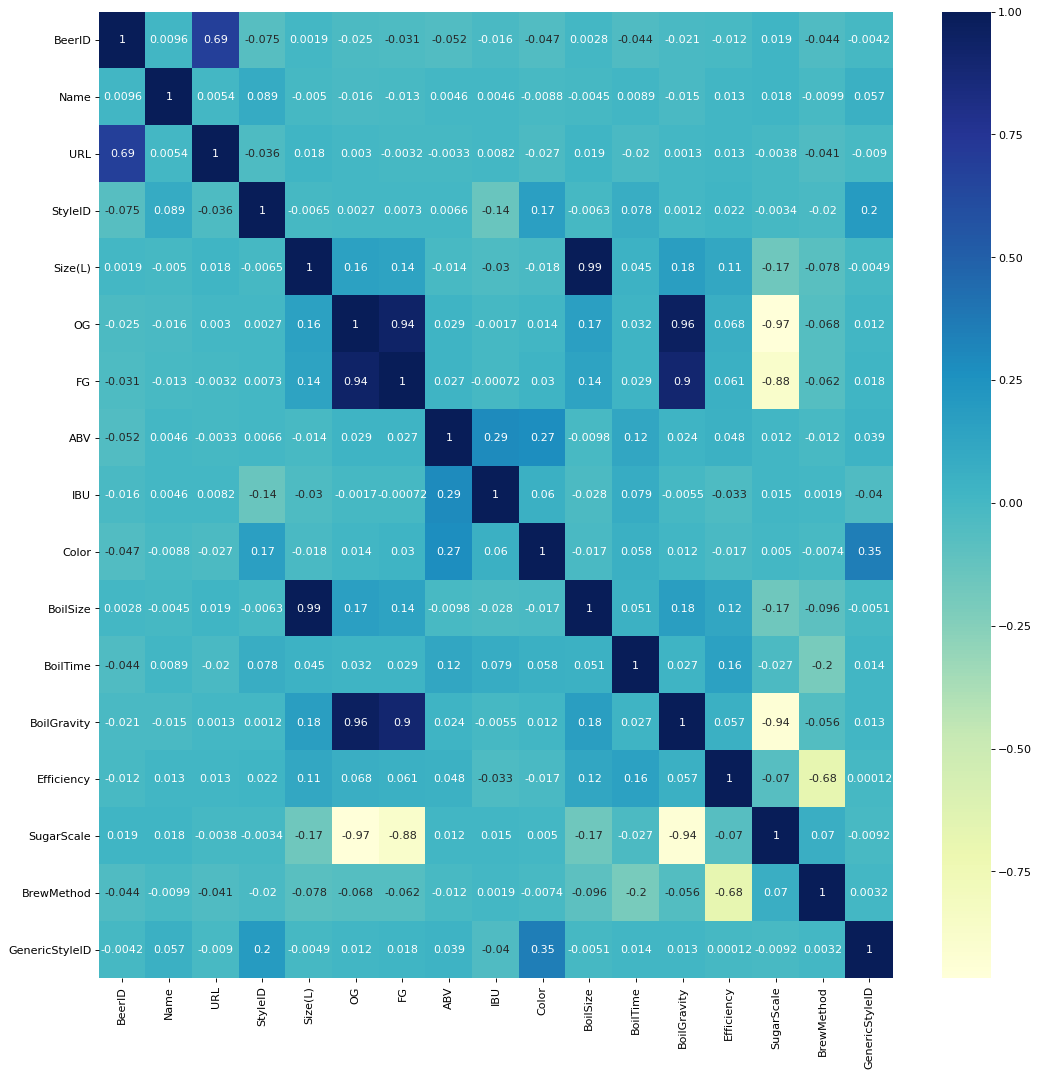

In [17]:
plt.figure(figsize=(16, 16), dpi=80)
sns.heatmap(recipe_dataset.corr(), annot=True, cmap="YlGnBu")

Podemos ver como sí que tiene más correlación este nuevo atributo, aun que sea gracias a que se reduce la classificación

---

# Modelos y Entrenamiento

Primeramente extraeremos los atributos Style y GenericStyle ya que son de tipo string y porque ya tenemos sus atributos complementarios de tipo int (StyleID y GenericStyleID).

Quiero trabajar con los dos tarjet, como he comentado antes, uno con los 175 estilos que ya vienen por defecto, y otro con la división que en grupos más grandes.

In [18]:
recipe_dataset = recipe_dataset.drop(['Style', 'GenericStyle'], axis=1)
print(recipe_dataset.head())

   BeerID   Name    URL  StyleID  Size(L)     OG     FG   ABV    IBU  Color  \
0       1  55828   2447       45    21.77  1.055  1.013  5.48  17.65   4.83   
1       2  50102   2468       85    20.82  1.083  1.021  8.16  60.65  15.64   
2       3  58937  68304        7    18.93  1.063  1.018  5.91  59.25   8.98   
3       4  58935  68248        7    22.71  1.061  1.017  5.80  54.48   8.50   
4       5   6957  73415       20    50.00  1.060  1.010  6.48  17.84   4.57   

   BoilSize  BoilTime  BoilGravity  Efficiency  SugarScale  BrewMethod  \
0     28.39        75        1.038        70.0           1           0   
1     24.61        60        1.070        70.0           1           0   
2     22.71        60        1.047        70.0           1           3   
3     26.50        60        1.047        70.0           1           0   
4     60.00        90        1.050        72.0           1           0   

   GenericStyleID  
0               0  
1               5  
2               3  


In [19]:
X = recipe_dataset.drop(['StyleID', 'GenericStyleID'], axis=1)
Y_s = recipe_dataset['StyleID']
Y_gs = recipe_dataset['GenericStyleID']

print(Y_s.head(), Y_gs.head())

0    45
1    85
2     7
3     7
4    20
Name: StyleID, dtype: int64 0    0
1    5
2    3
3    3
4    0
Name: GenericStyleID, dtype: int32


Para dividir los datos de entrenamiento y de test, utilizaremos el 80-20 ya que suele ser el más utilizado normalmente, y estandarizamos la X para poder trabajar mejor

In [20]:
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(X, Y_s, train_size=0.8)
X_train_gs, X_test_gs, Y_train_gs, Y_test_gs = train_test_split(X, Y_gs, train_size=0.8)

In [21]:
scaler_s = StandardScaler()
scaler_gs = StandardScaler()

scaler_s.fit(X_train_s)
scaler_gs.fit(X_train_gs)

X_train_s = scaler_s.transform(X_train_s)
X_test_s = scaler_s.transform(X_test_s)
X_train_gs = scaler_gs.transform(X_train_gs)
X_test_gs = scaler_gs.transform(X_test_gs)

Antes de empezar a comparar modelos, modificaremos los diferentes hyperparametros de cada uno de ellos para lograr el más óptimo o el que mejor resultados nos da. Esto lo llevaremos a cabo con un GridSearch manual y los evaluaremos con el f1 score macro para que no afecte que nuestro dataset no esté balanceado.

Inicializamos los diferentes parametros para cada modelo:

In [22]:
hyp_c = [0.01, 0.1, 1.0, 10]
hyp_tol = [0.0001, 1, 1000]
hyp_criterion = ['gini', 'entropy']
hyp_n_estimators = [100, 200, 300]
hyp_min_samples_leaf = [1, 2, 3]

### Regresión Logística

In [23]:
print("Regresión Logística")
for c in hyp_c:
    lr_s = LogisticRegression(C=c)
    lr_gs = LogisticRegression(C=c)

    lr_s.fit(X_train_s, Y_train_s)
    print ("F1 score Style:         ", f1_score(Y_test_s, lr_s.predict(X_test_s), average='macro'))

    lr_gs.fit(X_train_gs, Y_train_gs)
    print ("F1 score GenericStyle:  ", f1_score(Y_test_gs, lr_gs.predict(X_test_gs), average='macro'))

    print("C:", c)
    print("")

Regresión Logística
F1 score Style:          0.031420249549703336
F1 score GenericStyle:   0.24404169007705276
C: 0.01

F1 score Style:          0.050305938265672326
F1 score GenericStyle:   0.2581982376625981
C: 0.1

F1 score Style:          0.06009749558930048
F1 score GenericStyle:   0.2589823924444667
C: 1.0

F1 score Style:          0.06235540105798805
F1 score GenericStyle:   0.2585666730325355
C: 10



Podemos ver que el mejor hyperparámetro para la Regresión Logística para el target Style es C=10, y para GenericStyle es C=1

### Random Forest

In [24]:
rf_models = []
print("RandomForest")
for e in hyp_n_estimators:
    for s in hyp_min_samples_leaf:
        rf_s = RandomForestClassifier(n_estimators=e, min_samples_leaf=s)
        rf_gs = RandomForestClassifier(n_estimators=e, min_samples_leaf=s)
        
        rf_s.fit(X_train_s, Y_train_s)
        print ("F1 score Style:         ", f1_score(Y_test_s, rf_s.predict(X_test_s), average='macro'))

        rf_gs.fit(X_train_gs, Y_train_gs)
        print ("F1 score GenericStyle:  ", f1_score(Y_test_gs, rf_gs.predict(X_test_gs), average='macro'))
        
        print("N_estimators:", e, "- Min_samples_leaf", s)
        print("")

RandomForest
F1 score Style:          0.16228251509641564
F1 score GenericStyle:   0.4635066495165169
N_estimators: 100 - Min_samples_leaf 1

F1 score Style:          0.15345542001501697
F1 score GenericStyle:   0.45665346072501645
N_estimators: 100 - Min_samples_leaf 2

F1 score Style:          0.1503870930283741
F1 score GenericStyle:   0.43650054584208237
N_estimators: 100 - Min_samples_leaf 3

F1 score Style:          0.16486308558118629
F1 score GenericStyle:   0.46238220065802693
N_estimators: 200 - Min_samples_leaf 1

F1 score Style:          0.15072465312895172
F1 score GenericStyle:   0.4540247573040143
N_estimators: 200 - Min_samples_leaf 2

F1 score Style:          0.14520418331356832
F1 score GenericStyle:   0.43405547976907927
N_estimators: 200 - Min_samples_leaf 3

F1 score Style:          0.16387902827935413
F1 score GenericStyle:   0.46345777678637806
N_estimators: 300 - Min_samples_leaf 1

F1 score Style:          0.15424065960897357
F1 score GenericStyle:   0.45958782

Podemos ver que los mejores hyperparámetros para el Random forest son n_estimators=200 para Style, n_estimatos=100 para GenericStyle, y min_samples_leaf=1 para ambos casos

### Decision Tree

In [25]:
print("Decision Tree")
for c in hyp_criterion:
    dt_s = DecisionTreeClassifier(random_state=0, criterion=c)
    dt_gs = DecisionTreeClassifier(random_state=0, criterion=c)

    dt_s.fit(X_train_s, Y_train_s)
    print ("F1 score Style:         ", f1_score(Y_test_s, dt_s.predict(X_test_s), average='macro'))

    dt_gs.fit(X_train_gs, Y_train_gs)
    print ("F1 score GenericStyle:  ", f1_score(Y_test_gs, dt_gs.predict(X_test_gs), average='macro'))

    print("Criterion:", c)
    print("")

Decision Tree
F1 score Style:          0.1123056073685654
F1 score GenericStyle:   0.3716018062432864
Criterion: gini

F1 score Style:          0.09895491662789191
F1 score GenericStyle:   0.39268361931125084
Criterion: entropy



Podemos ver que el mejor hyperparámetro para el Decision Tree para Style es criterion=gini, y para GenericStyle es criterion=entropy

### Ada Boost

In [26]:
print("Ada Boost")
for e in hyp_n_estimators:
    ab_s = AdaBoostClassifier(n_estimators=e, random_state=0)
    ab_gs = AdaBoostClassifier(n_estimators=e, random_state=0)

    ab_s.fit(X_train_s, Y_train_s)
    print ("F1 score Style:         ", f1_score(Y_test_s, ab_s.predict(X_test_s), average='macro'))

    ab_gs.fit(X_train_gs, Y_train_gs)
    print ("F1 score GenericStyle:  ", f1_score(Y_test_gs, ab_gs.predict(X_test_gs), average='macro'))

    print("N_estimators:", e)
    print("")

Ada Boost
F1 score Style:          0.008015318957001336
F1 score GenericStyle:   0.3705354126273045
N_estimators: 100

F1 score Style:          0.008015318957001336
F1 score GenericStyle:   0.3338775690800795
N_estimators: 200

F1 score Style:          0.007786085824542399
F1 score GenericStyle:   0.3031365815893681
N_estimators: 300



Podemos ver que el mejores hyperparámetro para Ada Boost es n_estimators=100 para ambos casos. Vemos que para el target Style no varia demasiado que modifiquemos este parámetro.

---

# Validación y Estudio

Una vez tenemos los mejores parámetros para cada modelo, los validaremos con Cross Validation con f1 macro, ya que seguimos teniendo el mismo problema del desbalance, y miraremos cual es el mejor de todos, el cual estudiaremos.

Utilizaremos 10 folds ya que es lo que se suele usar de normal.

### Regresión Logística

In [27]:
lr_s = LogisticRegression(C=10)
lr_s.fit(X_train_s, Y_train_s)
cross_val_lr_s = cross_val_score(lr_s, X_train_s, Y_train_s, cv=10, scoring='f1_macro')
print("Cross Validation Score Style:        ", cross_val_lr_s.mean(), "std", cross_val_lr_s.std())

lr_gs = LogisticRegression(C=1)
lr_gs.fit(X_train_gs, Y_train_gs)
cross_val_lr_gs = cross_val_score(lr_gs, X_train_gs, Y_train_gs, cv=10, scoring='f1_macro')
print("Cross Validation Score GenericStyle: ", cross_val_lr_gs.mean(), "std", cross_val_lr_gs.std())

Cross Validation Score Style:         0.059265566180627394 std 0.003952793719661186
Cross Validation Score GenericStyle:  0.2717211262082433 std 0.015013338738393682


### Random Forest

In [28]:
rf_s = RandomForestClassifier(n_estimators=200, min_samples_leaf=1)
rf_s.fit(X_train_s, Y_train_s)
cross_val_rf_s = cross_val_score(rf_s, X_train_s, Y_train_s, cv=10, scoring='f1_macro')
print("Cross Validation Score Style:        ", cross_val_rf_s.mean(), "std", cross_val_rf_s.std())

rf_gs = RandomForestClassifier(n_estimators=100, min_samples_leaf=1)
rf_gs.fit(X_train_gs, Y_train_gs)
cross_val_rf_gs = cross_val_score(rf_gs, X_train_gs, Y_train_gs, cv=10, scoring='f1_macro')
print("Cross Validation Score GenericStyle: ", cross_val_rf_gs.mean(), "std", cross_val_rf_gs.std())

Cross Validation Score Style:         0.15752976203124927 std 0.006265248276640948
Cross Validation Score GenericStyle:  0.4586095739868024 std 0.01923710948311362


### Decision Tree

In [29]:
dt_s = DecisionTreeClassifier(random_state=0, criterion='gini')
dt_s.fit(X_train_s, Y_train_s)
cross_val_dt_s = cross_val_score(dt_s, X_train_s, Y_train_s, cv=10, scoring='f1_macro')
print("Cross Validation Score Style:        ", cross_val_dt_s.mean(), "std", cross_val_dt_s.std())

dt_gs = DecisionTreeClassifier(random_state=0, criterion='entropy')
dt_gs.fit(X_train_gs, Y_train_gs)
cross_val_dt_gs = cross_val_score(dt_gs, X_train_gs, Y_train_gs, cv=10, scoring='f1_macro')
print("Cross Validation Score GenericStyle: ", cross_val_dt_gs.mean(), "std", cross_val_dt_gs.std())

Cross Validation Score Style:         0.1082045674887108 std 0.0028773401438192707
Cross Validation Score GenericStyle:  0.3813871621079711 std 0.014561973410033248


### Ada Boost

In [30]:
ab_s = AdaBoostClassifier(n_estimators=100, random_state=0)
ab_s.fit(X_train_s, Y_train_s)
cross_val_ab_s = cross_val_score(ab_s, X_train_s, Y_train_s, cv=10, scoring='f1_macro')
print("Cross Validation Score Style:        ", cross_val_ab_s.mean(), "std", cross_val_ab_s.std())

ab_gs = AdaBoostClassifier(n_estimators=100, random_state=0)
ab_gs.fit(X_train_gs, Y_train_gs)
cross_val_ab_gs = cross_val_score(ab_gs, X_train_gs, Y_train_gs, cv=10, scoring='f1_macro')
print("Cross Validation Score GenericStyle: ", cross_val_ab_gs.mean(), "std", cross_val_ab_gs.std())

Cross Validation Score Style:         0.008848505824585117 std 0.0016855703058400284
Cross Validation Score GenericStyle:  0.361103941143934 std 0.020856930152575653


In [31]:
#Target Style
models_s = pd.DataFrame(columns=["model", "mean", "std"])
models_s = models_s.append({'model': 'Regresión Logística', 'mean': cross_val_lr_s.mean(), 'std': cross_val_lr_s.std()}, ignore_index=True)
models_s = models_s.append({'model': 'Random Forest', 'mean': cross_val_rf_s.mean(), 'std': cross_val_rf_s.std()}, ignore_index=True)
models_s = models_s.append({'model': 'Decision Tree', 'mean': cross_val_dt_s.mean(), 'std': cross_val_dt_s.std()}, ignore_index=True)
models_s = models_s.append({'model': 'Ada Boost', 'mean': cross_val_ab_s.mean(), 'std': cross_val_ab_s.std()}, ignore_index=True)
models_s.sort_values(by="mean", ascending=False)

,model,mean,std
1,Random Forest,0.157530,0.006265
2,Decision Tree,0.108205,0.002877
0,Regresión Logística,0.059266,0.003953
3,Ada Boost,0.008849,0.001686


In [32]:
#Target GenericStyle
models_gs = pd.DataFrame(columns=["model", "mean", "std"])
models_gs = models_gs.append({'model': 'Regresión Logística', 'mean': cross_val_lr_gs.mean(), 'std': cross_val_lr_gs.std()}, ignore_index=True)
models_gs = models_gs.append({'model': 'Random Forest', 'mean': cross_val_rf_gs.mean(), 'std': cross_val_rf_gs.std()}, ignore_index=True)
models_gs = models_gs.append({'model': 'Decision Tree', 'mean': cross_val_dt_gs.mean(), 'std': cross_val_dt_gs.std()}, ignore_index=True)
models_gs = models_gs.append({'model': 'Ada Boost', 'mean': cross_val_ab_gs.mean(), 'std': cross_val_ab_gs.std()}, ignore_index=True)
models_gs.sort_values(by="mean", ascending=False)

,model,mean,std
1,Random Forest,0.458610,0.019237
2,Decision Tree,0.381387,0.014562
3,Ada Boost,0.361104,0.020857
0,Regresión Logística,0.271721,0.015013


El mejor modelo para los dos targets es el RandomForest

---

Observamos que incluso el mejor modelo devuelve unos resultados muy bajos, así que vamos a intentar estudiar porqué esto sucede.

In [33]:
predictions_s = rf_s.predict(X_test_s)
cm_s = confusion_matrix(Y_test_s, predictions_s, labels=rf_s.classes_)
disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=rf_s.classes_)

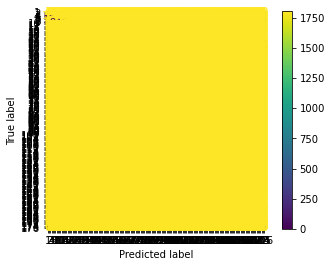

In [34]:
disp_s.plot()

In [35]:
predictions_gs = rf_gs.predict(X_test_gs)
cm_gs = confusion_matrix(Y_test_gs, predictions_gs, labels=rf_gs.classes_)
disp_gs = ConfusionMatrixDisplay(confusion_matrix=cm_gs, display_labels=rf_gs.classes_)

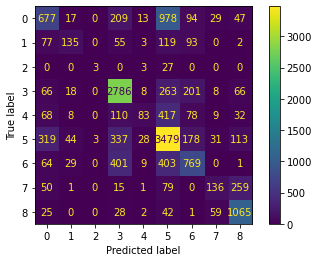

In [36]:
disp_gs.plot()

Así de primeras podemos ver que al tener tanto que clasificar, la Confusion Matrix del target Style es ilegible y no podemos sacar ninguna conclusión.

Para nuestro otro target sí que podemos ver mejor los resultados de la clasificación.
Observamos que en las clases donde tenemos una gran cantidad de datos, la clasificación que debería tener es medianamente acertada ya que tiene una gran proporción correcta, aunque luego la cantidad de fallos esté distribuída en unac clases en concreto.
Por otro lado, las que tienen menos datos, tienen una proporción más elevada de fallos, lo que al final genera que tengamos esos resultados en el cross validaion.

---

In [37]:
print(classification_report(Y_test_s, predictions_s))

              precision    recall  f1-score   support

           1       0.57      0.14      0.23        28
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.30      0.44      0.36       408
           5       0.44      0.41      0.42        74
           6       0.25      0.39      0.30       224
           7       0.52      0.76      0.62      2362
           8       0.25      0.02      0.04        43
           9       0.31      0.27      0.29       466
          10       0.39      0.63      0.48      1498
          11       0.21      0.33      0.26       137
          12       0.32      0.37      0.34       282
          13       0.05      0.03      0.04        37
          14       0.29      0.11      0.16       141
          15       0.23      0.16      0.19       108
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         9
          18       0.00    

In [38]:
print(classification_report(Y_test_gs, predictions_gs))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40      2064
           1       0.54      0.28      0.37       484
           2       0.50      0.09      0.15        33
           3       0.71      0.82      0.76      3416
           4       0.55      0.10      0.17       805
           5       0.60      0.77      0.67      4532
           6       0.54      0.46      0.50      1676
           7       0.50      0.25      0.33       541
           8       0.67      0.87      0.76      1222

    accuracy                           0.62     14773
   macro avg       0.57      0.44      0.46     14773
weighted avg       0.60      0.62      0.59     14773



Como podíamos concluir de la ConfusionMatrix, las clases con menos datos de soporte generan mucho más fallo y menos f1 score. Y por lo general como en todos los casos que hemos ido estudiando, el target GenericStyle tiene unos mejores resultados.

---

# Conclusión

Como nuestros modelos tienen que entrenar y clasificar de base una cantidad de 176 tipos diferentes, encima sin tener las variables bien distribuidas ya que hay de algunas más cantidad que de otras, obtenemos unos resultados muy bajos. 

Por ello, los modelos entrenados con el target GenericStyle que reduce las clases, aumenta casi el doble los resultados obtenidos, porque al clasificar menos por norma fallará menos veces.  
Viendo las matrices de confusión vemos que no destaca ninguna clasificación en concreto, ya que en la mayoría tienen un número medio elevado de fallos aunque acierte gran parte, entonces los resultados obtenidos los atribuiremos a la correlación de las variables, que como hemos visto, con nuestros target es practicamente mínima.